In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt 

In [2]:
import matplotlib.pyplot as plt 
import numpy as np 
from scipy.sparse import kron , eye , identity
from scipy.sparse.linalg import eigsh 


In [3]:
# Spin Operator (set hbar = 1 ) 
Sx = 0.5 * np.array([[0,1],[1,0]])
Sy = 0.5 * np.array([[0, -1j],[1j, 0]])
Sz = 0.5 * np.array([[1,0],[0,-1]])

In [4]:
# Construct the S^{+} operator; S^{-} is the hermitian conjugate of S^{+}, therefore no need to define 
Splus = Sx + 1j * Sy

In [6]:
# Block elements
sysBlock_Ham = np.zeros(Sx.shape)
sysBlock_Splus = Splus 
sysBlock_Sz = Sz 
sysBlock_Length = 1

# Environment elements: 
envBlock_Ham = np.zeros(Sx.shape)
envBlock_Splus = Splus 
envBlock_Sz = Sz 
envBlock_Length = 1

In [7]:
# Define the maximum number of Sites that we want to reach and the maximum number of lowest eigenstates that we would keep: 
LatticeLength = 200
MaximalStates = 32

In [8]:
# Local dimension for a site. In Heisenberg model, each site is described by a 2x2 matrix, impliying there are 2 states at one point 
Dim = 2

# Interaction Strength of Heisenberg Model 
J = 1 

# To store the ground state energy of eahc DMRG step
E_GS = [] 

In [9]:
def partial_trace(psi,n1,n2):
    # define the density matrix for ground state psi
    rho =  psi @ psi.conj().T
    rho_tensor = rho.reshape(int(n1), int(n2),int(n1),int(n2))
    RDM_sys = np.trace(rho_tensor, axis1=1, axis2=3)
    RDM_env = np.trace(rho_tensor, axis1=0, axis2=2)
    return RDM_sys, RDM_env

In [10]:
# Stop the while loop if (sys + env) length reach to 200
while (sysBlock_Length + envBlock_Length) < LatticeLength:
    # Update the sysBlock: add a site on RHS 
    # kron(sysBlock_Ham, identity(Dim)) = initialize the sysBlock_Ham eg: 2 Dim case: 
    # kron(sysBlock_Ham, identity(Dim)) = 0_{4x4} matrix > initialize the sysBlock_Ham in 4D
    # print(kron(sysBlock_Splus, Splus.conj().T).toarray().shape)

    sysBlock_Ham = kron(sysBlock_Ham, eye(Dim))+\
                   J/2 * (kron(sysBlock_Splus, Splus.conj().T) + kron(sysBlock_Splus.conj().T, Splus)) + J * kron(sysBlock_Sz, Sz)

    #Update the envBlock: add a site on LHS ( this update part could be done in a clever way using kron?)
    envBlock_Ham = kron(eye(Dim),envBlock_Ham) + \
                   J/2 * (kron(Splus.conj().T,envBlock_Splus) + kron(Splus, envBlock_Splus.conj().T) ) + J * kron(Sz, envBlock_Sz)


    # Make sure the Hamiltonian that we defined are Hermitian: 
    sysBlock_Ham = (sysBlock_Ham + sysBlock_Ham.conj().T) / 2
    envBlock_Ham = (envBlock_Ham + envBlock_Ham.conj().T) / 2


    # Construct the spin oerators of the newly added sites on middle: 
    # sysBlock_Splus = I \otimes Splus ; envBlock_Splus = Splus \otimes I s.t.
    # Interaction of these two point = I \otimes Splus \otimes Splus \otimes I 
    sysBlock_Splus = kron(eye(len(sysBlock_Ham.toarray())/Dim), Splus)
    sysBlock_Sz = kron(eye(len(sysBlock_Ham.toarray())/Dim), Sz)
    envBlock_Splus = kron(Splus, eye(len(envBlock_Ham.toarray())/Dim))
    envBlock_Sz = kron(Sz,eye(len(envBlock_Ham.toarray())/Dim))

    # Update the length
    sysBlock_Length = sysBlock_Length + 1
    envBlock_Length = envBlock_Length + 1




    # Merger two blocks together to form a superblock 
    # 1. New sysBlock = sysBlock \otimes I_{dim = sysBlock} and similar for envBlock
    # 2. Include the interaction of the middle sites: Use Heisenberg Hamiltonian: 
    # 3. Add all stuff together to form the superblock Hamiltonian
    Hsuper = kron(sysBlock_Ham, eye(len(envBlock_Ham.toarray()))) + kron(eye(len(envBlock_Ham.toarray())), envBlock_Ham) \
        + J/2 * (kron(sysBlock_Splus.conj().T, envBlock_Splus) + kron(sysBlock_Splus, envBlock_Splus.conj().T)) + J * kron(sysBlock_Sz, envBlock_Sz)

    # Return the ground state of superblock
    # the vec_GS is (n, 1) array, not a (1,n) array as usual 
    val_GS, vec_GS = eigsh(Hsuper, 1, which="SA", return_eigenvectors=True)


    # Store the ground state energy of superBlock under each iteration
    E_GS.append( val_GS/(sysBlock_Length + envBlock_Length))


    # Compute the parital trace of the ground state density matrix. These can be computed by tensor network 
    sysBlock_DM, envBlock_DM = partial_trace(vec_GS,  len(sysBlock_Ham.toarray()), len(envBlock_Ham.toarray()))


    # Ensure the RDM of each Block is Hermitian
    sysBlock_DM = (sysBlock_DM + sysBlock_DM.conj().T)/2
    envBlock_DM = (envBlock_DM + envBlock_DM.conj().T)/2


    # Diagonalize the reduced density matrix
    sysBlock_weight, sysBlock_rotationMatrix = np.linalg.eig(sysBlock_DM)
    envBlock_weight, envBlock_rotationMatrix = np.linalg.eig(envBlock_DM)
    

    """ Sorted Method using Numpy """
    # This part can be done with using argsort 
    # Then idx tells us the descending order of weights of RDM
    sysBlock_idx = sysBlock_weight.argsort()[::-1]
    sysBlock_weight_sort = sysBlock_weight[sysBlock_idx]
    Isys = sysBlock_idx # call this idex and Isys

    # Similar for the environment: 
    envBlock_idx = envBlock_weight.argsort()[::-1]
    envBlock_weight_sort = envBlock_weight[envBlock_idx]
    Ienv = envBlock_idx


    """ Truncation of the Hamiltonina"""
    # Obtain the new set of bases with highest weightings
    # If the dimension of eigenvector matrix is larger than the Maximum States, then we set a cut off here
    # Only extract the states with higher weightings
    # Isys[:min(MaximalStates, len(sysBlock_rotationMatrix) ) ] scans the higher weightings column vector of the eigenvector             matrix 
    sysBlock_rotationMatrix = sysBlock_rotationMatrix[:, Isys[:min(MaximalStates, len(sysBlock_rotationMatrix) ) ]  ]
    envBlock_rotationMatrix = envBlock_rotationMatrix[:, Ienv[:min(MaximalStates, len(envBlock_rotationMatrix) ) ]  ]

    #Project the Hamiltonian into lower dimensional subspace spanned by sysBlock_rot_matrix 
    # sysblock:
    sysBlock_Ham = sysBlock_rotationMatrix.conj().T @ sysBlock_Ham.toarray() @ sysBlock_rotationMatrix
    sysBlock_Splus = sysBlock_rotationMatrix.conj().T @ sysBlock_Splus.toarray() @ sysBlock_rotationMatrix
    sysBlock_Sz = sysBlock_rotationMatrix.conj().T @ sysBlock_Sz.toarray() @ sysBlock_rotationMatrix
    # envBlock
    envBlock_Ham = envBlock_rotationMatrix.conj().T @ envBlock_Ham.toarray() @ envBlock_rotationMatrix
    envBlock_Splus = envBlock_rotationMatrix.conj().T @ envBlock_Splus.toarray() @ envBlock_rotationMatrix
    envBlock_Sz = envBlock_rotationMatrix.conj().T @ envBlock_Sz.toarray() @ envBlock_rotationMatrix


    print("Total length =", sysBlock_Length + envBlock_Length)

Total length = 4
Total length = 6
Total length = 8
Total length = 10
Total length = 12
Total length = 14
Total length = 16
Total length = 18
Total length = 20
Total length = 22
Total length = 24
Total length = 26
Total length = 28
Total length = 30
Total length = 32
Total length = 34
Total length = 36
Total length = 38
Total length = 40
Total length = 42
Total length = 44
Total length = 46
Total length = 48
Total length = 50
Total length = 52
Total length = 54
Total length = 56
Total length = 58
Total length = 60
Total length = 62
Total length = 64
Total length = 66
Total length = 68
Total length = 70
Total length = 72
Total length = 74
Total length = 76
Total length = 78
Total length = 80
Total length = 82
Total length = 84
Total length = 86
Total length = 88
Total length = 90
Total length = 92
Total length = 94
Total length = 96
Total length = 98
Total length = 100
Total length = 102
Total length = 104
Total length = 106
Total length = 108
Total length = 110
Total length = 112
Total 

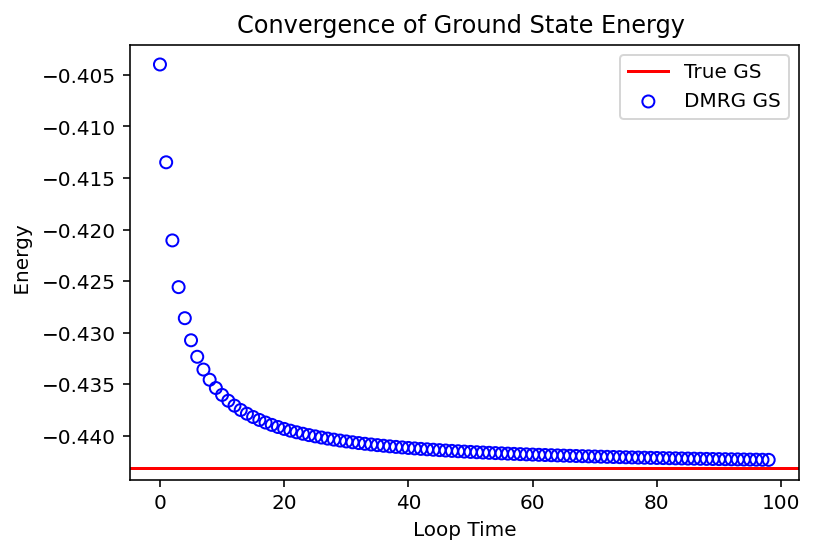

In [11]:
length_array = np.arange(0,len(E_GS),1)
plt.title(r"Convergence of Ground State Energy ")
plt.scatter(length_array, np.array(E_GS) ,facecolors='none', edgecolors='b' ,label=r"DMRG GS" )
plt.axhline(y=-np.log(2) + 0.25, color='r', linestyle='-', label=r"True GS")
plt.ylabel(r" Energy")
plt.xlabel(r"Loop Time")
plt.legend()
plt.show()